# Phishing Detection Using BERT and ELECTRA <br> Pre-Trained Models from Transformers

### Katherine Haynes <br> Fall, 2020

# 1A BERT

**BERT**, or **B**idirectional **E**mbedding **R**epresentations from **T**ransformers, is a method of pre-training language representations which obtains state-of-the-art results on a wide array of Natural Language Processing (NLP) tasks. The academic paper can be found here: https://arxiv.org/abs/1810.04805.  

# 1B ELECTRA
The ELECTRA model is a pretraining approach that uses a generator and a discriminator.  The generator replaces tokens in a sequence and is trained as a masked language model.  The discriminator identifies which tokens were replaced by the generator in the sequence.  The model is described in the paper: </br>
Clark, K., Luong, M.-T., Le, Q.V., & Manning, C.D. (2020).  Pre-training text encoders as discriminators rather than generators, ICLR, https://openreview.net/pdf?id=r1xMH1BtvB.

## Reference Notebooks
This notebook is based on two notebooks: </b>
- <a href=https://github.com/elsanns/xai-nlp-notebooks/blob/master/electra_fine_tune_interpret_captum_ig.ipynb>Fine-Tuning Electra</a>
- <a href=https://huggingface.co/transformers/custom_datasets.html>Fine-Tuning with Custom Datasets</a>

# 2 Setup

In [21]:
useGoogle = True
useTPU = True

DATA_COLUMN = 'url'
LABEL_COLUMN = 'Y'
LABEL_LIST = [0, 1]
LABEL_NAMES = ['Legit','Phish']

ELECTRA_OR_BERT = 'bert'
ELECTRA_MODEL = 'small'   #Options: small, base, large
BERT_MODEL = 'base'  #Options: base, basec, large

### Load Libraries

In [2]:
# Load Basic Libraries
import itertools
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Import Tensorflow
import tensorflow as tf
from tensorflow import keras
print("Using TensorFlow {}".format(tf.__version__))

Using TensorFlow 2.3.0


In [4]:
# Import Transformers
!pip install transformers==3.5.1
import transformers
from transformers import (BertTokenizer,
                          TFBertForSequenceClassification,
                          ElectraTokenizerFast, 
                          TFElectraForSequenceClassification, 
                          TFTrainer, TFTrainingArguments)
print("Using Transformers version {}".format(transformers.__version__))

     |████████████████████████████████| 1.3MB 5.3MB/s 
     |████████████████████████████████| 2.9MB 15.3MB/s 
     |████████████████████████████████| 890kB 29.5MB/s 
     |████████████████████████████████| 1.1MB 46.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f897428171acdf0b3726042ef54a7c47e5d206bb78c0a6a1b33f851aae48f8f8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Using Transformers version 3.5.1


In [5]:
# Setup TPU/GPU
useGPU=False
if useGoogle:
    if useTPU:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU!")
        print("  Number of accelerators: {}".format( \
                                      strategy.num_replicas_in_sync))
        
        #tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        #print('Running on TPU ', resolver.cluster_spec().as_dict()['worker'])
        
        # Setup to not save output
        #tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        #print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        #tf.config.experimental_connect_to_cluster(tpu)
        #tf.tpu.experimental.initialize_tpu_system(tpu)
        #strategy = tf.distribute.experimental.TPUStrategy(tpu)
        #print("REPLICAS: ", strategy.num_replicas_in_sync)
                
    else:
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            print('Using GPU!')
            useGPU=True
            try:
                # Currently, memory growth needs to be the same across GPUs
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            except RuntimeError as e:
                # Memory growth must be set before GPUs have been initialized
                print(e)
        else:
            print('Using CPU!')

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.118.27.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.118.27.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU!
  Number of accelerators: 8


In [6]:
# Setup TPU Buckets
if useTPU:
    from google.colab import auth
    auth.authenticate_user()

    CLOUD_BUCKET = 'electra'
    BUCKET = 'gs://' + CLOUD_BUCKET
    print("Saving To Bucket: {}".format(BUCKET))

Saving To Bucket: gs://electra


In [7]:
# Setup Google Storage
if useGoogle:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Set I/O Directories
if useGoogle:
    if useTPU:
        INPUT_DIR = './'
        OUTPUT_DIR = BUCKET + '/'
    else:
        INPUT_DIR = '/content/drive/My Drive/cs533/saveCombo/'
        OUTPUT_DIR = '/content/drive/My Drive/cs533/'
        print('Writing Dir: {}'.format(OUTPUT_DIR))
else:
    INPUT_DIR = '../bertANN/saveCombo/'
    OUTPUT_DIR = './'

### Define Data Functions

In [9]:
# Shuffle Two Arrays
def shuffle_XY(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [10]:
# Create 50/50 Dataset
def create_5050(X, Y):
    refPhish = np.where(Y == 1)[0]
    nPhish = len(refPhish)
    refLegit = np.where(Y == 0)[0]
        
    XTrain0 = [X[i] for i in refLegit]
    XTrain1 = [X[i] for i in refPhish]
        
    #YTrain0 = [YTrain[i] for i in range(nTrain) if YTrain[i] == 0]
    #YTrain1 = [YTrain[i] for i in range(nTrain) if YTrain[i] == 1]
    YTrain0 = Y[refLegit]
    YTrain1 = Y[refPhish]

    XTrain = XTrain0[:nPhish] + XTrain1
    YTrain = np.concatenate((YTrain0[:nPhish],YTrain1),axis=0)
    shuffle_XY(XTrain,YTrain)

    nPhish2 = len(np.where(YTrain == 1)[0])
    if (nPhish2 != nPhish):
        print('Error Loading 50/50 Dataset')
        
    return XTrain, YTrain

In [11]:
# Function to preprocess the urls
def preprocess_url(text):
    # create sentence by making words
    
    # lowercase text
    text = str(text).lower()
    
    # remove non-UTF
    text.encode("utf-8", "ignore").decode()
    
    # break apart URL by punctuation and numbers
    regex_tokenizer = nltk.RegexpTokenizer("\d+|[a-z]+|\W")
    textlist = regex_tokenizer.tokenize(text)
    
    # join back together,
    # making sure there are not double spaces
    textOut = " ".join(textlist).replace('  ',' ')
    
    return textOut

### Define Plotting Functions

In [12]:
# PLOT CONFUSION MATRIX
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    NOTE: Modified from output of scikit learn!  
    EXPECTS: [[tp, fp],[fn,tn]]
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    #plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    colm = np.array([["white","black"],["black","white"]])
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=colm[i,j])

    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('Truth')
  
    return figure

### Define Trainer Functions

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support( \
                                labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 3 Data

In [16]:
useCombo = True
use5050 = True
useToken = False

loadTrain = True
loadTrFile = INPUT_DIR + 'TrainAllCombo8020.pkl'

loadTest = True
loadTeFile = INPUT_DIR + 'TestAllCombo8020.pkl'

### Load

In [17]:
# Load the training data
if loadTrain:
    if useTPU:
       !cp '/content/drive/My Drive/cs533/saveCombo/TrainAllCombo8020.pkl' .

    with open(loadTrFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        
    if useCombo:
        XTrain = allTemp[1]
        YTrain = allTemp[2]
    else:
        XTrain = allTemp[0]
        YTrain = allTemp[1]
    del allTemp
    
    if use5050:
        XTrain, YTrain = create_5050(XTrain,YTrain)
        
    if useToken:
        XTrain = [preprocess_url(i) for i in XTrain]

    # Split the training data for validation  
    trX, tvX, trY, tvY = train_test_split( \
            XTrain, YTrain.tolist(), shuffle=True, test_size=0.2)

    # Print info
    nTrain = len(XTrain)
    nPhish = len(np.where(YTrain == 1)[0])
    print('Loaded Train:  {:d} Samples, {:.1f}% Phishing'.format(
                  nTrain, nPhish/nTrain*100.))

    # Create a dataframe
    DFTrain = pd.DataFrame.from_dict({
            DATA_COLUMN: XTrain,
            LABEL_COLUMN: YTrain})
    display(DFTrain.head(4))

Loaded Train:  24310 Samples, 50.0% Phishing


url  Y
0  docs.google.com/forms/d/e/1FAIpQLScww73vYBfnjM...  1
1     dailyexclusiveoffer.com/wp-admin/em/yahoo/mail  1
2  curefans.com/index.php?PHPSESSID=gfdq3e3l8cquk...  0
3  autorizador5.com.br/landpage/img/icons/verifie...  1

In [18]:
# Load the testing data
if loadTest:
    if useTPU:
       !cp '/content/drive/My Drive/cs533/saveCombo/TestAllCombo8020.pkl' .

    with open(loadTeFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        
    if useCombo:
        XTest = allTemp[1]
        YTest = allTemp[2]
    else:
        XTest = allTemp[0]
        YTest = allTemp[1]
    del allTemp
    
    if use5050:
        XTest, YTest = create_5050(XTest,YTest)

    if useToken:
        XTest = [preprocess_url(i) for i in XTest]
        
    # Print info
    nTest = len(XTest)
    nPhish = len(np.where(YTest == 1)[0])
    print('Loaded Test:  {:d} Samples, {:.1f}% Phishing'.format(
          nTest, nPhish/nTest*100.))

    # Create a dataframe
    DFTest = pd.DataFrame.from_dict({
            DATA_COLUMN: XTest,
            LABEL_COLUMN: YTest})
    display(DFTest.head(4))

Loaded Test:  6078 Samples, 50.0% Phishing


url  Y
0  www.jay-parts.com/shop/ethen/zubehoer/?add_to_...  0
1  onedrive.live.com/?authkey=!AIuSZYYWONlw6wQ&am...  1
2  sandyfarmer.blogspot.com/2017/06/sunday-post-2...  0
3     waraimasu.blog40.fc2.com/blog-entry-81831.html  0

### Tokenize

In [22]:
# Load the tokenizer
if ELECTRA_OR_BERT == 'bert':
  if BERT_MODEL == 'base':
    print('Using bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained(
        "bert-base-uncased")
  elif BERT_MODEL == 'basec':
    print('Using bert-base-cased')
    tokenizer = BertTokenizer.from_pretrained(
        "bert-base-cased")
  elif BERT_MODEL == 'large':
    print('Using bert-large-uncased')
    tokenizer = BertTokenizer.from_pretrained(
        "bert-large-uncased")
  else:
    print('Unrecognized BERT_MODEL option: {}'.format(BERT_MODEL))

elif ELECTRA_OR_BERT == 'electra':
  if ELECTRA_MODEL == 'small':
    print('Using electra-small-discriminator')
    tokenizer = ElectraTokenizerFast.from_pretrained(
        "google/electra-small-discriminator", do_lower_case=True)
  elif ELECTRA_MODEL == 'base':
    print('Using electra-base-discriminator')
    tokenizer = ElectraTokenizerFast.from_pretrained(
        "google/electra-base-discriminator", do_lower_case=True)
  elif ELECTRA_MODEL == 'large':
    print('Using electra-large-discriminator')
    tokenizer = ElectraTokenizerFast.from_pretrained(
        "google/electra-large-discriminator", do_lower_case=True)
  else:
    print('Unrecognized ELECTRA_MODEL option: {}'.format(ELECTRA_MODEL))

else:
  print('Unrecognized Model Choice: {}'.format(ELECTRA_OR_BERT))

Using bert-base-uncased


In [23]:
# Encode the training data
if loadTrain:
    train_encodings = tokenizer(trX, truncation=True, padding=True)
    val_encodings = tokenizer(tvX, truncation=True, padding=True)

In [24]:
# Turn training encodings into a Dataset object
if loadTrain:
    train_dataset = tf.data.Dataset.from_tensor_slices((
       dict(train_encodings),
       trY
    ))
    val_dataset = tf.data.Dataset.from_tensor_slices((
       dict(val_encodings),
       tvY
    ))

In [25]:
# Encode the testing data
if loadTest:
    test_encodings = tokenizer(XTest, truncation=True, padding=True)

In [26]:
# Turn testing encodings into a Dataset object
if loadTest:
    test_dataset = tf.data.Dataset.from_tensor_slices((
       dict(test_encodings),
       YTest
    ))

# 4 Fine-Tune Using TFTrainer (GPU)

### Setup trainer

In [ ]:
# Setup parameters
if not useTPU:
  if ELECTRA_OR_BERT == 'electra':
     if ELECTRA_MODEL == 'small':
        print('Using Electra Small Arguments')
        training_args = TFTrainingArguments(
            output_dir=OUTPUT_DIR,            # output directory
            evaluation_strategy="steps",      # evaluation strategy
            num_train_epochs=3,               # total number of training epochs
            per_device_train_batch_size=32,  # batch size per device during training
            per_device_eval_batch_size=32,   # batch size for evaluation
            per_gpu_train_batch_size=32,
            per_gpu_eval_batch_size=32,
            warmup_steps=10000,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,   # strength of weight decay
            learning_rate=5.e-4, # Adam learning rate
            adam_epsilon=1.e-6,  # Adam epsilon
        )

        with training_args.strategy.scope():
            model = TFElectraForSequenceClassification.from_pretrained(
                    "google/electra-small-discriminator")
        
     elif ELECTRA_MODEL == 'base':
        print('Using Electra Base Arguments')
        training_args = TFTrainingArguments(
            output_dir=OUTPUT_DIR,           # output directory
            evaluation_strategy="steps",     # evaluation strategy
            num_train_epochs=3,              # total number of training epochs
            per_device_train_batch_size=8, # batch size per device during training
            per_device_eval_batch_size=8,   # batch size for evaluation
            per_gpu_train_batch_size=8,
            per_gpu_eval_batch_size=8, 
            warmup_steps=10000,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,   # strength of weight decay
            learning_rate=2e-4,  # Adam learning rate
            adam_epsilon=1e-6,   # Adam epsilon
        )

        with training_args.strategy.scope():
            model = TFElectraForSequenceClassification.from_pretrained(
                    "google/electra-base-discriminator")
        
     elif ELECTRA_MODEL == 'large':
        print('Using Electra Large Arguments')
        training_args = TFTrainingArguments(
            output_dir=OUTPUT_DIR,           # output directory
            evaluation_strategy="steps",     # evaluation strategy
            num_train_epochs=3,              # total number of training epochs
            per_device_train_batch_size=2048, # batch size per device during training
            per_device_eval_batch_size=2048,  # batch size for evaluation
            warmup_steps=10000,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,   # strength of weight decay
            learning_rate=2e-4,  # Adam learning rate
            adam_epsilon=1e-6,   # Adam epsilon
        )

        with training_args.strategy.scope():
            model = TFElectraForSequenceClassification.from_pretrained(
                    "google/electra-large-discriminator")

     else:
        print("Invalid ELECTRA_MODEL: {}".format(ELECTRA_MODEL))
        print("Using small with defaults.....")

        training_args = TFTrainingArguments(
            output_dir=OUTPUT_DIR,            # output directory
            evaluation_strategy="steps",      # evaluation strategy
            num_train_epochs=3,               # total number of training epochs
            per_device_train_batch_size=16,  # batch size per device during training
            per_device_eval_batch_size=64,   # batch size for evaluation
            warmup_steps=500,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,     # strength of weight decay
        )

        with training_args.strategy.scope():
            model = TFElectraForSequenceClassification.from_pretrained(
                    "google/electra-small-discriminator")
            
  elif ELECTRA_OR_BERT == 'bert':
     if BERT_MODEL == 'base':
        print('Using BERT Base Arguments')
        training_args = TFTrainingArguments(
            output_dir=OUTPUT_DIR,            # output directory
            evaluation_strategy="steps",      # evaluation strategy
            num_train_epochs=3,               # total number of training epochs
            per_device_train_batch_size=16,  # batch size per device during training
            per_device_eval_batch_size=16,   # batch size for evaluation
            per_gpu_train_batch_size=16,
            per_gpu_eval_batch_size=16,
            warmup_steps=10000,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,   # strength of weight decay
            learning_rate=8.e-5, # Adam learning rate
            adam_epsilon=1.e-6,  # Adam epsilon
        )

        with training_args.strategy.scope():
            model = TFBertForSequenceClassification.from_pretrained(
                    "bert-base-uncased")
        
     elif BERT_MODEL == 'basec':
        print('Using BERT BaseC Arguments')
        training_args = TFTrainingArguments(
            output_dir=OUTPUT_DIR,           # output directory
            evaluation_strategy="steps",     # evaluation strategy
            num_train_epochs=3,              # total number of training epochs
            per_device_train_batch_size=16, # batch size per device during training
            per_device_eval_batch_size=16,   # batch size for evaluation
            per_gpu_train_batch_size=16,
            per_gpu_eval_batch_size=16, 
            warmup_steps=10000,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,   # strength of weight decay
            learning_rate=8e-5,  # Adam learning rate
            adam_epsilon=1e-6,   # Adam epsilon
        )

        with training_args.strategy.scope():
            model = TFBertForSequenceClassification.from_pretrained(
                    "bert-base-cased")
        
     elif BERT_MODEL == 'large':
        print('Using BERT Large Arguments')
        training_args = TFTrainingArguments(
            output_dir=OUTPUT_DIR,           # output directory
            evaluation_strategy="steps",     # evaluation strategy
            num_train_epochs=3,              # total number of training epochs
            per_device_train_batch_size=16, # batch size per device during training
            per_device_eval_batch_size=16,  # batch size for evaluation
            warmup_steps=10000,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,   # strength of weight decay
            learning_rate=8e-5,  # Adam learning rate
            adam_epsilon=1e-6,   # Adam epsilon
        )

        with training_args.strategy.scope():
            model = TFElectraForSequenceClassification.from_pretrained(
                    "bert-large-uncased")
            
     else:
        print('Unknown BERT Model: {}'.format(BERT_MODEL))

  else:
    print('Unknown Option: {}'.format(ELECTRA_OR_BERT))

In [ ]:
# Setup the trainer
if not useTPU:
    trainer = TFTrainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=val_dataset,            # evaluation dataset
        compute_metrics=compute_metrics      # evaluation metrics
    )

### Train (Fine-Tune)

In [ ]:
# Train
if not useTPU:
    start = time.time()
    trainer.train()
    stop = time.time()
    print("Fine-Tuning Time: {:.2f}".format(stop-start))

### Check Using Tensorboard

In [ ]:
useTensorBoard = False

In [ ]:
# Load TensorBoard
if not useTPU and useTensorBoard:
    %load_ext tensorboard
    %tensorboard --logdir runs

### Evaluate

In [ ]:
evalGPU = True

In [ ]:
# Evaluate
if not useTPU and evalGPU:
    model_result = trainer.evaluate()
    print("Accuracy: {}".format(model_result['eval_accuracy']))

### Predict

In [ ]:
predictTrain = True
showTrain = True
saveTrain = True
saveTrainFile = OUTPUT_DIR + 'BGPU_Predicted_Train.pkl'

predictTest = True
showTest = True
saveTest = True
saveTestFile = OUTPUT_DIR + 'BGPU_Predicted_Test.pkl'

In [ ]:
# Predict the output on the training dataset
if not useTPU and predictTrain:
    pred_train = trainer.predict(train_dataset)
    trlabels = pred_train.label_ids
    trpreds = pred_train.predictions.argmax(-1)

    if saveTrain:
        with open(saveTrainFile, 'wb') as handle:
            pickle.dump([trpreds, trX, trY, trlabels], handle, 
                       protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Show the output on the training dataset
if not useTPU and predictTrain and showTrain:
    tn, fp, fn, tp = confusion_matrix(trlabels, trpreds).ravel()
    traccuracy = (tp + tn)/(tn + tp + fn + fp)
    traccuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
    print("Training Bal Accuracy: {:.3f}%".format(traccuracyB*100.))
    cmatrix = np.array([[tp, fp],[fn, tn]])
    disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'],
                                 cTitle='Training Confusion Matrix')

In [ ]:
# Predict the output on the testing dataset
if not useTPU and predictTest:
    pred_test = trainer.predict(test_dataset)
    telabels = pred_test.label_ids
    tepreds = pred_test.predictions.argmax(-1)

    if saveTest:
        with open(saveTestFile, 'wb') as handle:
            pickle.dump([tepreds, XTest, YTest, telabels], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Show the output on the testing dataset
if not useTPU and predictTest and showTest:
   tn, fp, fn, tp = confusion_matrix(telabels, tepreds).ravel()
   electra_accuracy = (tp + tn)/(tn + tp + fn + fp)
   electra_accuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
   print("Testing Bal Accuracy: {:.3f}%".format(electra_accuracyB*100.))
   cmatrix = np.array([[tp, fp],[fn, tn]])
   disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'],
                                cTitle='Testing Confusion Matrix')

# 5 Fine-Tune Using Native TensorFlow (TPU)

### Setup Model

In [27]:
# Setup Model
if useTPU and ELECTRA_OR_BERT == 'bert':
    if BERT_MODEL == 'base':
        with strategy.scope():
          model = TFBertForSequenceClassification.from_pretrained( 
              "bert-base-uncased")
    elif BERT_MODEL == 'basec':
        with strategy.scope():
          model = TFBertForSequenceClassification.from_pretrained(
              "bert-base-cased")
    elif BERT_MODEL == 'large':
        with strategy.scope():
          model = TFBertForSequenceClassification.from_pretrained(
              "bert-large-uncased")
            
elif useTPU and ELECTRA_OR_BERT == 'electra':
    if ELECTRA_MODEL == 'small':
        with strategy.scope():
             model = TFElectraForSequenceClassification.from_pretrained(
                     "google/electra-small-discriminator")
    elif ELECTRA_MODEL == 'base':
        with strategy.scope():
            model = TFElectraForSequenceClassification.from_pretrained(
                     "google/electra-base-discriminator")
    elif ELECTRA_MODEL == 'large':
        with strategy.scope():
            model = TFElectraForSequenceClassification.from_pretrained(
                     "google/electra-large-discriminator")
            
elif useTPU:
  print("Unknown Model Option: {}".format(ELECTRA_OR_BERT))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Compile

In [28]:
myLR = 8e-5  # Learning Rate

In [29]:
# Compile
if useTPU:
    optimizer = tf.keras.optimizers.Adam(learning_rate=myLR)
    #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    #model.compile(optimizer=optimizer,loss=loss,metrics=["mae", "acc"])
    model.compile(optimizer=optimizer, loss=model.compute_loss, 
                  metrics=["mae","acc"])

### Pre-Train

In [30]:
myEpoch = 2  # Number of epochs
myDBS = 128   # Data Batch Size
myVBS = 128   # Validation Batch Size

In [31]:
# Fit (Fine-Tune)
if useTPU:
    start=time.time()
    model.fit(train_dataset.batch(myDBS), epochs=myEpoch, batch_size=myDBS, 
              validation_data=val_dataset.batch(myVBS), validation_batch_size=myVBS)
    stop=time.time()
    print("Fine-Tune Time: {:.2f}s".format(stop-start))

Epoch 1/2
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


  2/152 [..............................] - ETA: 1:01:09 - loss: 0.6966 - mae: 0.5719 - acc: 0.5547WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0079s vs `on_train_batch_end` time: 0.4991s). Check your callbacks.


152/152 [==============================] - ETA: 0s - loss: 0.2294 - mae: 1.6524 - acc: 0.9045WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0036s vs `on_test_batch_end` time: 0.1359s). Check your callbacks.


152/152 [==============================] - 185s 1s/step - loss: 0.2294 - mae: 1.6524 - acc: 0.9045 - val_loss: 0.1447 - val_mae: 2.3376 - val_acc: 0.9471
Epoch 2/2
152/152 [==============================] - 83s 548ms/step - loss: 0.0855 - mae: 2.4973 - acc: 0.9702 - val_loss: 0.1266 - val_mae: 2.3794 - val_acc: 0.9554
Fine-Tune Time: 309.98s


### Evaluate

In [ ]:
evalTPU = False

In [ ]:
if useTPU and evalTPU:
    model_eval = model.evaluate(test_datset.batch[128])

### Predict

In [32]:
predictTrainTPU = True
showTrainTPU = True
saveTrainTPU = False
saveTrainFTPU = 'BLarge2c_Predicted_Train.pkl'

predictTestTPU = True
showTestTPU = True
saveTestTPU = False
saveTestFTPU = 'BLarge2c_Predicted_Test.pkl'

In [33]:
# Make and save training predictions
if useTPU and predictTrainTPU:
    pred_train = model.predict(train_dataset.batch(128))
    trLogits = pred_train[0]
    trProb = tf.nn.softmax(trLogits).numpy()
    trPreds = np.argmax(trProb, axis=-1)

    if saveTrainTPU:
        with open(saveTrainFTPU, 'wb') as handle:
            pickle.dump([trPreds, trX, trY], handle, 
                       protocol=pickle.HIGHEST_PROTOCOL)
        !cp $saveTrainFTPU '/content/drive/My Drive/cs533/saveBertLarge/'

Training Bal Accuracy: 97.355%


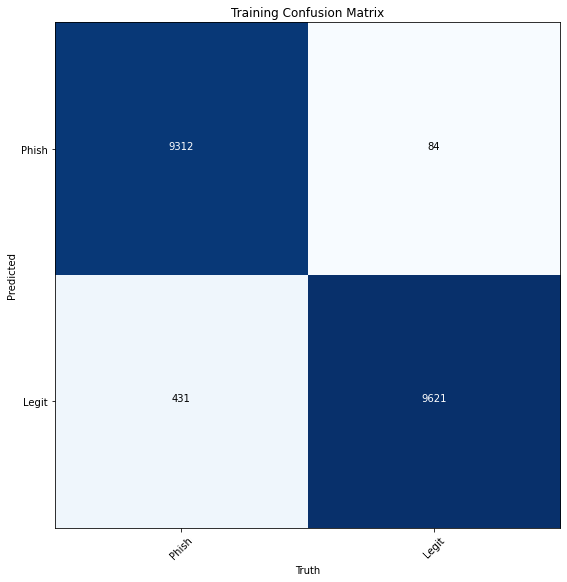

In [ ]:
# See training results
if useTPU and predictTrainTPU and showTrainTPU:
    tn, fp, fn, tp = confusion_matrix(trY, trPreds).ravel()
    traccuracy = (tp + tn)/(tn + tp + fn + fp)
    traccuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
    print("Training Bal Accuracy: {:.3f}%".format(traccuracyB*100.))
    cmatrix = np.array([[tp, fp],[fn, tn]])
    disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'],
                                 cTitle='Training Confusion Matrix')

In [34]:
# Make and save testing results
if useTPU and predictTestTPU:
    pred_test = model.predict(test_dataset.batch(128))
    teLogits = pred_test[0]
    teProb = tf.nn.softmax(teLogits).numpy()
    tePreds = np.argmax(teProb, axis=-1)

    if saveTestTPU:
        with open(saveTestFTPU, 'wb') as handle:
            pickle.dump([tePreds, XTest, YTest], handle, 
                       protocol=pickle.HIGHEST_PROTOCOL)
        !cp $saveTestFTPU '/content/drive/My Drive/cs533/saveBertLarge/'

Testing Bal Accuracy: 95.508%


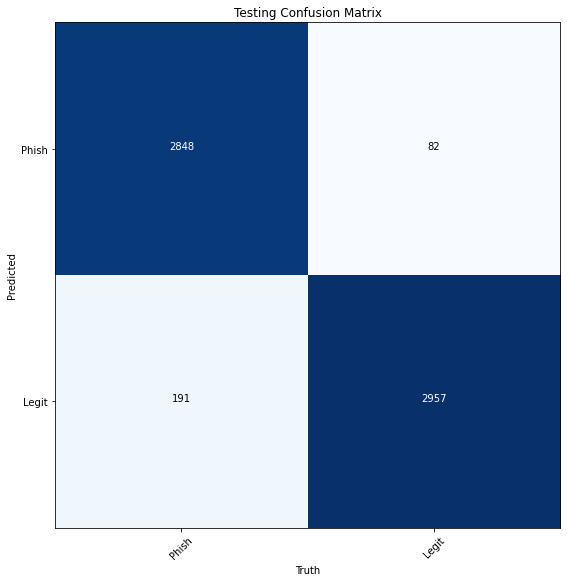

In [35]:
# See testing results
if useTPU and predictTestTPU and showTestTPU:
    # See Training Results
    tn, fp, fn, tp = confusion_matrix(YTest, tePreds).ravel()
    teaccuracy = (tp + tn)/(tn + tp + fn + fp)
    teaccuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
    print("Testing Bal Accuracy: {:.3f}%".format(teaccuracyB*100.))
    cmatrix = np.array([[tp, fp],[fn, tn]])
    disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'],
                                 cTitle='Testing Confusion Matrix')

### Predict on Original Full Training Dataset

In [36]:
predictFullTr = True
showFullTr = True
saveFullTr = True
saveFullTr = 'BERT_Predicted_TrAll.pkl'

In [37]:
# Load the full training data and predict
if useTPU and predictFullTr:
    with open(loadTrFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        
    if useCombo:
        XTrain = allTemp[1]
        YTrain = allTemp[2]
    else:
        XTrain = allTemp[0]
        YTrain = allTemp[1]
    del allTemp
            
    if useToken:
        XTrain = [preprocess_url(i) for i in XTrain]

    Xencodings = tokenizer(XTrain, truncation=True, padding=True)
    Xdataset = tf.data.Dataset.from_tensor_slices((
       dict(Xencodings),
       YTrain
    ))
    print('Reloaded Full Training Data: {} Samples'.format(len(YTrain)))



In [ ]:
# Predict the full training data
if useTPU and predictFullTr:
    predYTr = model.predict(Xdataset.batch(128))
    YTrLogits = predYTr[0]
    YTrProb = tf.nn.softmax(YTrLogits).numpy()
    YTrPreds = np.argmax(YTrProb, axis=-1)
    print('Predicted Full Training Data')

Training Bal Accuracy: 97.259%


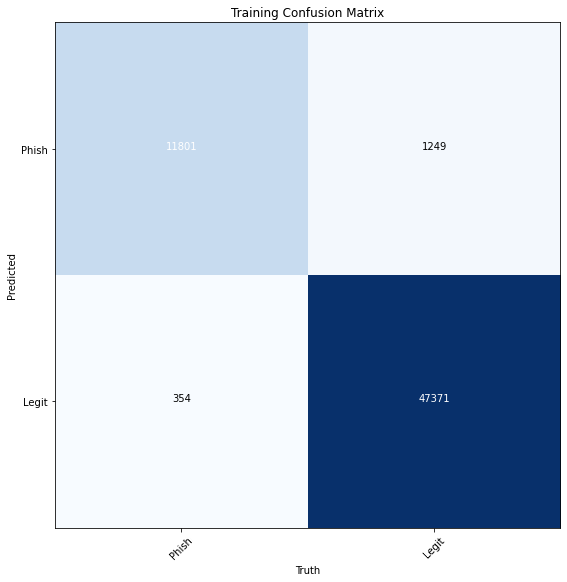

In [38]:
# See the full training results
if useTPU and predictFullTr and showFullTr:
    tn, fp, fn, tp = confusion_matrix(YTrain, YTrPreds).ravel()
    traccuracy = (tp + tn)/(tn + tp + fn + fp)
    traccuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
    print("Training Bal Accuracy: {:.3f}%".format(traccuracyB*100.))
    cmatrix = np.array([[tp, fp],[fn, tn]])
    disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'],
                                 cTitle='Training Confusion Matrix')

In [41]:
 # Save the full training results
if useTPU and saveFullTr:
    with open(saveFullTr, 'wb') as handle:
            pickle.dump([YTrPreds, XTrain, YTrain], handle, 
                       protocol=pickle.HIGHEST_PROTOCOL)
    !cp $saveFullTr '/content/drive/My Drive/cs533/saveBertBase/'
    print('Saved Full Training Data')

Saved Full Training Data


### Predict on Original Full Testing Dataset

In [48]:
predictFullTe = False
showFullTe = True
saveFullTe = True
saveFullTe = 'BERT_Predicted_TeAll.pkl'

In [49]:
# Load the full testing data
if useTPU and predictFullTe:
    with open(loadTeFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        
    if useCombo:
        XTest = allTemp[1]
        YTest = allTemp[2]
    else:
        XTest = allTemp[0]
        YTest = allTemp[1]
    del allTemp
            
    if useToken:
        XTest = [preprocess_url(i) for i in XTrain]

    Xencodings = tokenizer(XTest, truncation=True, padding=True)
    XTdataset = tf.data.Dataset.from_tensor_slices((
       dict(Xencodings),
       YTest
    ))
    print('Reloaded Full Training Data: {} Samples'.format(len(YTest)))

In [44]:
 # Predict full testing data
 if useTPU and predictFullTe:
    predYTe = model.predict(XTdataset.batch(128))
    YTeLogits = predYTe[0]
    YTeProb = tf.nn.softmax(YTeLogits).numpy()
    YTePreds = np.argmax(YTeProb, axis=-1)
    print('Predicted Full Training Data')

Predicted Full Training Data


Training Bal Accuracy: 95.537%


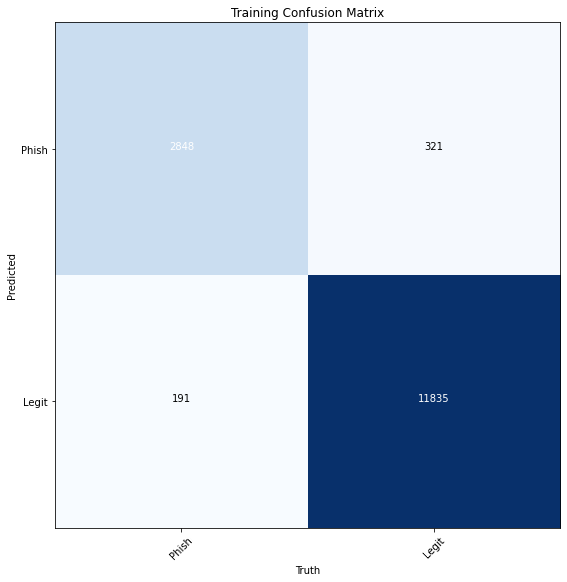

In [45]:
# See the full testing results
if useTPU and predictFullTe and showFullTe:
    tn, fp, fn, tp = confusion_matrix(YTest, YTePreds).ravel()
    traccuracy = (tp + tn)/(tn + tp + fn + fp)
    traccuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
    print("Training Bal Accuracy: {:.3f}%".format(traccuracyB*100.))
    cmatrix = np.array([[tp, fp],[fn, tn]])
    disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'],
                                 cTitle='Training Confusion Matrix')

In [47]:
 # Save the full testing results
if useTPU and saveFullTe:
    with open(saveFullTe, 'wb') as handle:
            pickle.dump([YTePreds, XTest, YTest], handle, 
                       protocol=pickle.HIGHEST_PROTOCOL)
    !cp $saveFullTe '/content/drive/My Drive/cs533/saveBertBase/'
    print('Saved Full Testing Data')

Saved Full Testing Data
